In [10]:
import numpy as np
import pandas as pd
from qiskit import QuantumRegister, ClassicalRegister, AncillaRegister, QuantumCircuit
from qiskit.quantum_info import Statevector, partial_trace

def apply_UR(circuit, ctrl, target_y, target_b, N):
    for j, y_qubit in enumerate(target_y):
        theta = -4 * np.pi * (2 ** j) / N
        circuit.mcry(theta, [y_qubit, target_b[0]], ctrl, [], mode=None)

def controlled_subtract_from_half(circuit, control, target, anc, index=0):
    """
    Implement: |1⟩|y⟩ → |1⟩|~y + 1⟩ = |1⟩|2^n - y⟩
    """
    n = len(target)

    # Step 1: Controlled bitwise NOT
    for i in range(n):
        circuit.cx(control, target[i])

    # Step 2: Controlled +1 (ripple-carry)
    circuit.ccx(control, target[0], anc[0])
    circuit.cx(control, target[0])

    for i in range(1, n):
        circuit.ccx(anc[i - 1], target[i], anc[i])
        circuit.cx(anc[i - 1], target[i])

    # Step 3: Uncompute ancilla
    for i in range(n):
        circuit.x(target[i])
    for i in reversed(range(1, n)):
        circuit.ccx(anc[i - 1], target[i], anc[i])

    circuit.ccx(control, target[0], anc[0])
    for i in range(n):
        circuit.x(target[i])



def qht_recursive(circuit, ctrl_anc, data, anc):
    if len(data) == 1:
        circuit.h(data[0])
        return

    target_data = data[1:]
    qht_recursive(circuit, ctrl_anc, target_data, anc)

    N = 2 ** len(data)  

    # Step 3: H on ancilla
    circuit.h(ctrl_anc[0])

    # Step 4: Controlled subtract from half
    #controlled_subtract_from_half(circuit, ctrl_anc[0], target_data[:-1], anc)
    controlled_subtract_from_half(circuit, ctrl_anc[0], target_data, anc )

    # Step 5: Apply UR
    apply_UR(circuit, ctrl=ctrl_anc[0], target_y=target_data, target_b=[data[0]], N=N)

    controlled_subtract_from_half(circuit, ctrl_anc[0], target_data, anc)

    # Step 6: H on ancilla
    circuit.h(ctrl_anc[0])

    # Step 7: CNOT(ancilla, last data)
    #circuit.swap(data[0], ctrl_anc[0])
    circuit.cx(data[0], ctrl_anc[0])

    # Step 8: H on last data
    circuit.h(data[0])
    
    #swap
    for i in range(1,len(data)):
        circuit.swap(data[i],data[i-1])
    
    

def qht_clean(n):
    if n < 1:
        raise ValueError("n must be ≥ 1")

    ctrl_anc = QuantumRegister(1, name='a')
    data = QuantumRegister(n, name='q')
    anc = AncillaRegister(n-1, name='anc')

    circuit = QuantumCircuit(anc, data, ctrl_anc)
    qht_recursive(circuit, ctrl_anc, data, anc)
    return circuit



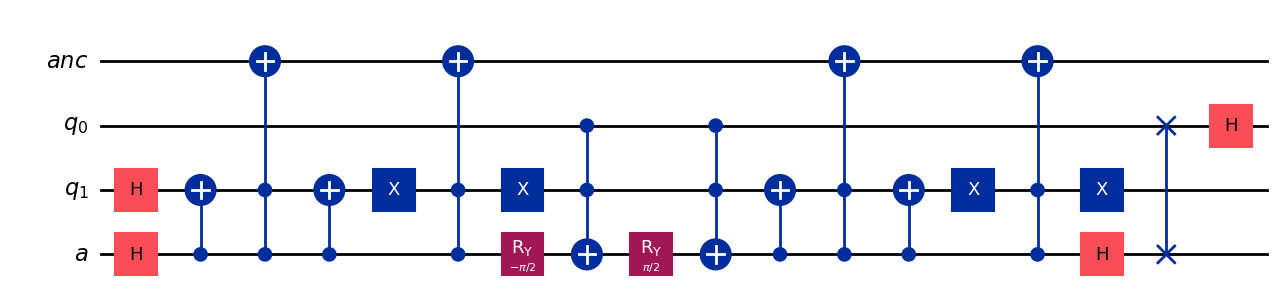

In [9]:
qc = qht_clean(n=2)
qc.draw('mpl')

In [11]:
def hartley_matrix(N):
    """
    discrete hartley transform
    """
    H = np.zeros((N, N))
    for k in range(N):
        for n in range(N):
            H[k, n] = np.cos(2 * np.pi * k * n / N) + np.sin(2 * np.pi * k * n / N)
    return H

def classical_hartley_output(bitstring):
    """
    classical hartley transform
    """
    N = 2 ** len(bitstring)
    vec = np.zeros(N)
    index = int(bitstring, 2)
    vec[index] = 1.0
    H = hartley_matrix(N)
    out = H @ vec
    normed = out / np.linalg.norm(out)  # compare after normalized
    return normed

def extract_data_register_amplitudes(sv, total_qubits, q_indices):
    """
    Extract marginal amplitude for q_indices (e.g., [2,1]) from a full statevector

    Args:
        sv: Statevector object
        total_qubits: number of total qubits (e.g., 4)
        q_indices: list of data qubit indices (e.g., [2,1] for q[1], q[0])
    
    Returns:
        np.ndarray of 2^n amplitudes
    """
    n = len(q_indices)
    out = np.zeros(2 ** n, dtype=complex)

    for i, amp in enumerate(sv):
        bin_str = f"{i:0{total_qubits}b}"[::-1]#  # little endian
        q_bits = ''.join([bin_str[j] for j in q_indices])
        q_idx = int(q_bits[::-1], 2)  # big endian result index [::-1]
        out[q_idx] += amp
    return out


def compare_qht_vs_classical(n, bitstring):
    print(f"\ninput |{bitstring}⟩ output：")
    
    # get vector
    qc = qht_clean(n)
    full_circ = QuantumCircuit(*qc.qregs)

    full_bits =   '0' + bitstring[::] + ''.join(['0' for i in range(n-1)])
    #full_bits =   '0' + bitstring
    index = int(full_bits, 2)
    sv = Statevector.from_int(index, dims=2**full_circ.num_qubits)

    for i in range(len(qc)):
        full_circ.append(qc[i], qc[i].qubits)
    evolved = sv.evolve(full_circ)

    qreg = qc.qregs[1]  # QuantumRegister('q')
    q_indices = [qc.qubits.index(qbit) for qbit in qreg]#[::-1] 

    quantum_out_data = extract_data_register_amplitudes(evolved.data, total_qubits=2**n, q_indices=q_indices)
   
    #quantum_out_data = extract_data_register_amplitudes(sv.data, total_qubits=2**n, q_indices=range(1,n+1)[::-1])
    #quantum_out = np.array(sv.data)
    #print(sv.data)

    # get classical output
    classical_out = classical_hartley_output(bitstring)

    '''
    reduced_rho = get_evolved_statevector(n, bitstring)  # returns DensityMatrix

    eigvals, eigvecs = np.linalg.eigh(reduced_rho.data)
    pure_state = eigvecs[:, np.argmax(eigvals)]  # 主振幅

    quantum_out_data = pure_state.real
    '''

    print("actual data:")
    print(np.round(quantum_out_data.real, 4))  
    #print(sv.data)

    print("expect Hartley normalized:")
    print(np.round(classical_out, 4))



compare_qht_vs_classical(n=2, bitstring="01")
compare_qht_vs_classical(n=2, bitstring="10")
compare_qht_vs_classical(n=2, bitstring="11")
compare_qht_vs_classical(n=2, bitstring="00")
#ancilla is 0 or 1, amp +- wrong
compare_qht_vs_classical(n=3, bitstring="111")
compare_qht_vs_classical(n=3, bitstring="011")

#ancilla is 0 or 1, amp correct
compare_qht_vs_classical(n=3, bitstring="010")
compare_qht_vs_classical(n=3, bitstring="101")
compare_qht_vs_classical(n=3, bitstring="001")

#ancilla is 0, amp correct
compare_qht_vs_classical(n=3, bitstring="100")
compare_qht_vs_classical(n=3, bitstring="000")


input |01⟩ output：
actual data:
[0.5 0.5 0.5 0.5]
expect Hartley normalized:
[ 0.5  0.5 -0.5 -0.5]

input |10⟩ output：
actual data:
[ 0.5  0.5  0.5 -0.5]
expect Hartley normalized:
[ 0.5 -0.5  0.5 -0.5]

input |11⟩ output：
actual data:
[ 0.5  0.5  0.5 -0.5]
expect Hartley normalized:
[ 0.5 -0.5 -0.5  0.5]

input |00⟩ output：
actual data:
[0.5 0.5 0.5 0.5]
expect Hartley normalized:
[0.5 0.5 0.5 0.5]

input |111⟩ output：
actual data:
[ 0.3536 -0.3536  0.5     0.5    -0.3536 -0.3536 -0.      0.    ]
expect Hartley normalized:
[ 0.3536 -0.     -0.3536 -0.5    -0.3536  0.      0.3536  0.5   ]

input |011⟩ output：
actual data:
[ 0.3536  0.3536  0.5    -0.5     0.3536 -0.3536  0.      0.    ]
expect Hartley normalized:
[ 0.3536  0.     -0.3536  0.5    -0.3536 -0.      0.3536 -0.5   ]

input |010⟩ output：
actual data:
[ 0.3536  0.3536  0.5    -0.5     0.3536 -0.3536  0.      0.    ]
expect Hartley normalized:
[ 0.3536  0.3536 -0.3536 -0.3536  0.3536  0.3536 -0.3536 -0.3536]

input |101⟩ outp

In [8]:
def debug_qht_evolution(n=2, bitstring='01'):
    qc = qht_clean(n)
    #qc = qc.decompose()
    full_circ = QuantumCircuit(*qc.qregs)  # use same qubit structure

    # 
    total_qubits = full_circ.num_qubits

    #  reversed bitstring （qiskit is little endian）
    #full_bits =   '0' + bitstring
    full_bits =   '0' + bitstring[::] + ''.join(['0' for i in range(n-1)]) # anc + q[0]...q[n-1]
    index = int(full_bits, 2)

    sv = Statevector.from_int(index, dims=2**total_qubits)  # Specify basis index 1 for all qubits

    for i in range(len(qc)): 
        full_circ.append(qc[i], qc[i].qubits)
        evolved = sv.evolve(full_circ)
        if i >= len(qc)-5:
            print(f"\ninput: {bitstring} Step {i}: {qc[i].name} {qc[i].qubits}")
            for idx, amp in enumerate(evolved):
                if np.abs(amp) > 1e-6:
                    bits = f"{idx:0{total_qubits}b}"
                    print(f"|{bits}⟩ : {amp.real:+.4f} {amp.imag:+.4f}j")


debug_qht_evolution(n=2, bitstring='00')
'''
debug_qht_evolution(n=2, bitstring='10')

debug_qht_evolution(n=2, bitstring='01')
debug_qht_evolution(n=2, bitstring='11')
'''
'''
debug_qht_evolution(n=3, bitstring='001')
debug_qht_evolution(n=3, bitstring='010')
debug_qht_evolution(n=3, bitstring='011')
debug_qht_evolution(n=3, bitstring='101')
debug_qht_evolution(n=3, bitstring='110')
debug_qht_evolution(n=3, bitstring='111')
'''
#debug_qht_evolution(n=3, bitstring='000')
#debug_qht_evolution(n=3, bitstring='100')





input: 00 Step 16: ccx (<Qubit register=(1, "a"), index=0>, <Qubit register=(2, "q"), index=1>, <AncillaQubit register=(1, "anc"), index=0>)
|0000⟩ : +0.5000 +0.0000j
|0100⟩ : +0.5000 +0.0000j
|1000⟩ : +0.5000 +0.0000j
|1100⟩ : +0.5000 +0.0000j

input: 00 Step 17: x (<Qubit register=(2, "q"), index=1>,)
|0000⟩ : +0.5000 +0.0000j
|0100⟩ : +0.5000 +0.0000j
|1000⟩ : +0.5000 +0.0000j
|1100⟩ : +0.5000 +0.0000j

input: 00 Step 18: h (<Qubit register=(1, "a"), index=0>,)
|0000⟩ : +0.7071 +0.0000j
|0100⟩ : +0.7071 +0.0000j

input: 00 Step 19: swap (<Qubit register=(2, "q"), index=0>, <Qubit register=(1, "a"), index=0>)
|0000⟩ : +0.7071 +0.0000j
|0100⟩ : +0.7071 +0.0000j

input: 00 Step 20: h (<Qubit register=(2, "q"), index=0>,)
|0000⟩ : +0.5000 +0.0000j
|0010⟩ : +0.5000 +0.0000j
|0100⟩ : +0.5000 +0.0000j
|0110⟩ : +0.5000 +0.0000j


"\ndebug_qht_evolution(n=3, bitstring='001')\ndebug_qht_evolution(n=3, bitstring='010')\ndebug_qht_evolution(n=3, bitstring='011')\ndebug_qht_evolution(n=3, bitstring='101')\ndebug_qht_evolution(n=3, bitstring='110')\ndebug_qht_evolution(n=3, bitstring='111')\n"